In [1]:
import os
import numpy as np
import pandas as pd

import pickle
import time


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
import seaborn as sns

# some prob need fitting now... 
#from utils_dce import test_val_train
from utils_rf import get_Xy_tt

#from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from IPython.display import clear_output

This script/notebok is designed to be by a bag an forth iterration, nudging me closer to the hp-ranges I want to use for the larger ensample.
It needs to be reassesed when I have the full set.
It can be slightly modified to accomodate XGboost instead of random forest. 

In [2]:
# get df:
pkl_file = open('/home/simon/Documents/Articles/conflict_prediction/data/computerome/currents/selected_features.pkl', 'rb')
#pkl_file = open('/home/projects/ku_00017/data/generated/currents/selected_features.pkl', 'rb')
selected_features = pickle.load(pkl_file)
pkl_file.close()

selected_features

,features,AP
0,cm_mu_l,0.181817
1,dce_mu,0.204768
2,dce_mu_s,0.215357
3,cm_mu_l_mass,0.220413
4,cm_mu_s_slope,0.219756
5,dce_mu_s_acc,0.220821
6,dce_mu_l,0.222964
7,dce_var_s,0.223614
8,cm_mu_s_mass,0.221354
9,dce_var,0.220981


In [3]:
X_train, y_train, X_test, y_test = get_Xy_tt(local = True)

X_train: (450648, 30)
y_train: (450648,)
X_test: (61452, 30)
y_test: (61452,)


In [4]:
n_rounds = 100

# SHOULD HAVE DEDICATED FEATURE SELECTION FOR XGBOOST!
best_features = selected_features['features'][:4].values # four first chosen features from forward featurte selection.

n_estimators_list = []
max_depth_list = []
gamma_list = []
reg_lambda_list = []

# see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html for more.

train_preds = []
test_preds = []

AUC_train_list = []
AP_train_list = []
BS_train_list = []

pr_train_list = []
roc_train_list = []

AUC_test_list = [] 
AP_test_list = []
BS_test_list = []

pr_test_list = []
roc_test_list = []

W_feature0_list = []
W_feature1_list = []

print('Beginning loop')
for i in range(n_rounds):

    # Constant hyper paremeters:


    # Variable hyper parameters
    n_estimators = np.random.randint(32,128)
    max_depth = np.random.randint(2,6)
    gamma = np.random.uniform(0.01, 1)
    reg_lambda = np.random.uniform(0.01, 0.9)
    
    
    model = XGBClassifier(n_estimators=n_estimators, max_depth = max_depth, gamma = gamma, reg_lambda = reg_lambda, random_state=42, n_jobs= 4, objective='binary:logistic', use_label_encoder=False)

    
    model.fit(X_train[best_features], y_train)

    y_train_pred = model.predict_proba(X_train[best_features])[:,1]
    y_test_pred = model.predict_proba(X_test[best_features])[:,1]

    AUC_train_list.append(metrics.roc_auc_score(y_train, y_train_pred))
    AP_train_list.append(metrics.average_precision_score(y_train, y_train_pred))
    BS_train_list.append(metrics.brier_score_loss(y_train, y_train_pred))

    precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_pred)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_train_pred)

    pr_train_list.append((precision_train, recall_train))
    roc_train_list.append((fpr_train, tpr_train))

    AUC_test_list.append(metrics.roc_auc_score(y_test, y_test_pred))
    AP_test_list.append(metrics.average_precision_score(y_test, y_test_pred))
    BS_test_list.append(metrics.brier_score_loss(y_test, y_test_pred))

    precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_pred)
    fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_test_pred)    

    pr_test_list.append((precision_test, recall_test))
    roc_test_list.append((fpr_test, tpr_test))
    
    n_estimators_list.append(n_estimators)
    max_depth_list.append(max_depth)
    gamma_list.append(gamma)
    reg_lambda_list.append(reg_lambda)
    
    train_preds.append(y_train_pred)
    test_preds.append(y_test_pred)


    print(f'{i+1}/{n_rounds} done')
    clear_output(wait = True)

[14:13:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
10/10 done


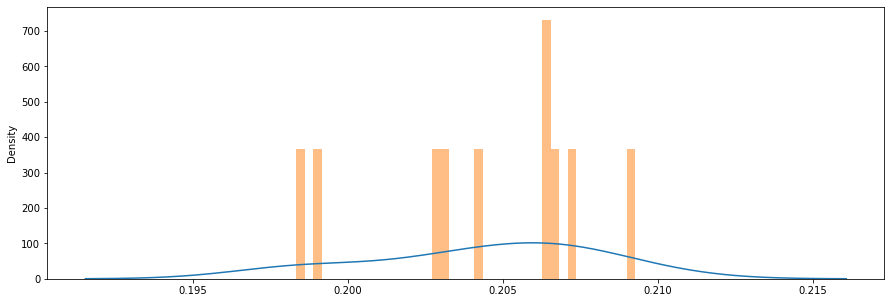

In [5]:
plt.figure(figsize = [15,5])
plt.hist(AP_test_list, bins = 40, density=True, alpha = 0.5, label = 'test', color = 'C1')
sns.kdeplot(AP_test_list)
plt.show()

In [6]:
hp_df = pd.DataFrame({'n_estimators' : n_estimators_list, 'max_depth' : max_depth_list, 'gamma' : gamma_list, 'reg_lambda' : reg_lambda_list, 
                      'test_preds' : test_preds, 'AP' : AP_test_list})

/home/simon/anaconda3/envs/xgb_env/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/simon/anaconda3/envs/xgb_env/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/simon/anaconda3/envs/xgb_env/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/simon/anaconda3/envs/xgb_env/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


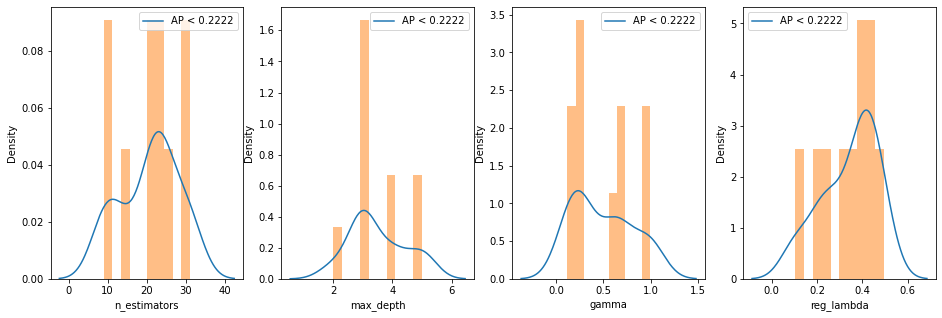

In [7]:
plt.figure(figsize = [20,5])

for i,j in enumerate(hp_df.columns[:4]):
    plt.subplot(1,5,i+1)

    sns.kdeplot(hp_df[hp_df['AP'] >= 0.2225][j], label = 'AP >= 0.2222', bw_method= 0.5) 
    sns.kdeplot(hp_df[hp_df['AP'] < 0.2225][j], label = 'AP < 0.2222', bw_method= 0.5)

    plt.hist(hp_df[hp_df['AP'] >= 0.2225][j], color = 'C0', density = True, alpha = 0.5) 
    plt.hist(hp_df[hp_df['AP'] < 0.2225][j], color = 'C1', density = True, alpha = 0.5)

    plt.legend()

plt.show()

#  I have looked at hte other parameters and there does not appear to be a relationship

# plt.scatter(hp_df['w0'], hp_df['w1'], c= hp_df['AP'])
# plt.xlabel('w0')
# plt.ylabel('w1')

# x_grid = np.arange(0.1,1.1,0.1)
# y_grid = x_grid * 0.52

# plt.plot(x_grid, y_grid)

# plt.show()

good values:
n_estimators: 

In [10]:
hp_df.sort_values('AP', ascending= False)[:5]

,n_estimators,max_depth,gamma,reg_lambda,test_preds,AP
4,31,4,0.992868,0.101812,"[6.0785216e-05, 6.0785216e-05, 6.0785216e-05, ...",0.209277
2,14,4,0.156106,0.434750,"[0.006734615, 0.006734615, 0.006734615, 0.0067...",0.207278
9,23,2,0.653787,0.456062,"[0.0005215995, 0.0005215995, 0.0005215995, 0.0...",0.206605
5,25,5,0.260073,0.394439,"[0.0002556079, 0.0002556079, 0.0002556079, 0.0...",0.206537
6,20,5,0.245523,0.496526,"[0.0011262837, 0.0011262837, 0.0011262837, 0.0...",0.206427


In [9]:
os.system("mpg123 /home/simon/Music/sounds/FF7Victory.mp3")

0

So from here you don't really have to pickle anything... Can you pickle a generator?

In [ ]:
rf_pred_mean = np.array(hp_df['test_preds']).mean(axis = 0)
rf_pred_std = np.array(hp_df['test_preds']).std(axis = 0)

random_ap_base = (y_test>0).mean()
rf_mean_precision, rf_mean_recall, _ = metrics.precision_recall_curve(y_test, rf_pred_mean) 
rf_mean_AP = metrics.average_precision_score(y_test, rf_pred_std)

rf_mean_fpr, rf_mean_tpr, _ =  metrics.roc_curve(y_test, rf_pred_mean) 
rf_mean_AUC = metrics.roc_auc_score(y_test, rf_pred_mean)

# -------------------------------------------------------------------------
# Fig
plt.figure(figsize = [22,8])

# ---------------------------------------------------------------------------
#PR/AP
plt.subplot(1,2,1)

plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')

plt.hlines(random_ap_base, 0, 1, linestyles='dashed', color = 'gray')

for i in pr_test_list: 
    
    plt.plot(i[1], i[0], color = 'blue', alpha = 0.1)
    
plt.plot(rf_mean_recall,rf_mean_precision, color = 'orange', alpha = 1)

    
rf_line = mlines.Line2D([], [], color='blue', marker='_', markersize=15, label='xgb')
rf_mean_line = mlines.Line2D([], [], color='orange', marker='_', markersize=15, label=f'xgb mean, AP: {rf_mean_AP:.2}')
random_ap_line = mlines.Line2D([], [], color='gray', linestyle='--', markersize=15, label='random baseline')

plt.legend(handles=[rf_line, rf_mean_line, random_ap_line],frameon = False, fontsize = 14)


# ---------------------------------------------------------------------------
#ROC/AUC
plt.subplot(1,2,2)

plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

for i in roc_test_list: 
    
    plt.plot(i[0], i[1], color = 'blue', alpha = 0.1)
    
plt.plot(rf_mean_fpr,rf_mean_tpr, color = 'orange', alpha = 1)

    
rf_line = mlines.Line2D([], [], color='blue', marker='_', markersize=15, label='xgb')
rf_mean_line = mlines.Line2D([], [], color='orange', marker='_', markersize=15, label=f'xgb mean, AP: {rf_mean_AUC:.2}')
random_auc_line = mlines.Line2D([], [], color='gray', linestyle='--', markersize=15, label='random baseline')

plt.legend(handles=[rf_line, rf_mean_line, random_auc_line],frameon = False, fontsize = 14)

plt.show()
